# Clustering

In [319]:
import pandas as pd
import numpy as np
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

import umap

from config import *
from clustering_utils import *

import warnings
warnings.filterwarnings("ignore")

## Load data

In [320]:
features_raw_new = pd.read_parquet(FEATURES_DIR / "all_features.pq")
features_raw_new.shape

(192, 520)

In [321]:
# Drop participants where all features are null
features = features_raw_new[~(features_raw_new.isna().sum(axis=1) == features_raw_new.shape[1]-2)]
features.shape

(171, 520)

In [322]:
y = pd.DataFrame(features["y"], columns=["y"])
X = features.drop(["participant_id", "y"], axis=1)
X.shape

(171, 518)

## Dimensionality Reduction

In [323]:
X_reduced = X.pipe(remove_low_variance_features).pipe(remove_multicollineraity, y).pipe(remove_outliers, 'MAD', 10.0)

2025-05-09 18:28:51,663 - INFO - clustering_utils.remove_low_variance_features:50 - Kept 463 features out of 518
2025-05-09 18:28:53,304 - INFO - clustering_utils.remove_multicollineraity:108 - Removed 164 highly correlated features: {'FIXATIONS_avg_pupil_size_max_fix', 'EVIL_BASTARD_saccades_per_second_mean', 'EVIL_BASTARD_distance_to_fixpoint_mean', 'FIXATIONS_saccades_per_second_mean', 'EVIL_BASTARD_fixations_per_second_min', 'KING_DEVICK_wrong_direction_saccade_pct_max', 'FIXATIONS_distance_to_fixpoint_mean', 'KING_DEVICK_duration_mean_fix', 'REACTION_avg_pupil_size_mean_fix', 'REACTION_peak_velocity_mean_sacc', 'KING_DEVICK_wrong_direction_saccade_pct_min', 'KING_DEVICK_avg_pupil_size_median_fix', 'EVIL_BASTARD_total_acceleration_magnitude_median', 'FITTS_LAW_fixations_per_second_min', 'SMOOTH_PURSUITS_x_fixation_dist_std', 'SMOOTH_PURSUITS_distance_to_fixpoint_y_mean', 'ANTI_SACCADE_avg_pupil_size_max_fix', 'SMOOTH_PURSUITS_duration_median_fix', 'FIXATIONS_amplitude_mean_sacc', '

In [324]:
X_reduced.shape

(171, 299)

## Choose Clustering Method

In [325]:
features_reduced = features[["participant_id", "y"] + list(X_reduced.columns)]

patients = features_reduced.query("y==1").drop(["participant_id", "y"], axis=1).dropna()
patients_std = pd.DataFrame(StandardScaler().fit_transform(patients), columns=patients.columns)


In [326]:
patients.shape

(55, 299)

In [159]:
umap_model = umap.UMAP(
    n_neighbors=15,         # smaller = more local focus, higher = more global
    min_dist=0.1,           # smaller = tighter clusters, higher = more spread
    n_components=2,         # use 2 for clustering/visualization (or 3)
    metric='manhattan',     # often better than 'euclidean' for clinical data
    random_state=42
)

In [197]:
optics_model = OPTICS(
    min_samples=5,
    xi=0.1,              # sensitivity for cluster detection (lower = more sensitive)
    min_cluster_size=0.05, # fraction or count of minimum cluster size
    metric=metric     # must match UMAP if used for clustering
)


In [ ]:
params = {
        "n_neighbors" : [5,15,30],
        "min_dist" : [0.01,0.1,0.5],
        "metric" : ["euclidean", "manhattan", "cosine"]
    }

In [310]:
def plot_umap(X, metric, n_neighbors, min_dist, ax):

    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,         # smaller = more local focus, higher = more global
        min_dist=min_dist,           # smaller = tighter clusters, higher = more spread
        n_components=2,         
        metric=metric,     
        random_state=42
    )
    optics_model = OPTICS(
        min_samples=5,
        xi=0.05,              # sensitivity for cluster detection (lower = more sensitive)
        min_cluster_size=0.05, # fraction or count of minimum cluster size
        metric=metric     # must match UMAP if used for clustering
    )
    
    X_transformed = umap_model.fit_transform(X)
    
    optics_model.fit(X_transformed)
    labels = optics_model.labels_
    
    # Generate a color palette that matches the UMAP scatter plot
    clusters = np.unique(labels[labels != -1])  # exclude noise for coloring
    palette = sns.color_palette("tab10", n_colors=len(clusters))
    label_color_map = {label: palette[i] for i, label in enumerate(clusters)}
    label_color_map[-1] = (0.85, 0.85, 0.85)

    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette=label_color_map, s=20, alpha=0.8, ax=ax, legend=False)
    
    # Layout
    ax.set_title(f"n_neighbors: {n_neighbors}\n min_dist: {min_dist}", fontsize=8) # Set title
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # Limit decimal precision on ticks
    ax.tick_params(axis='both', labelsize=6) # Reduce tick label font size

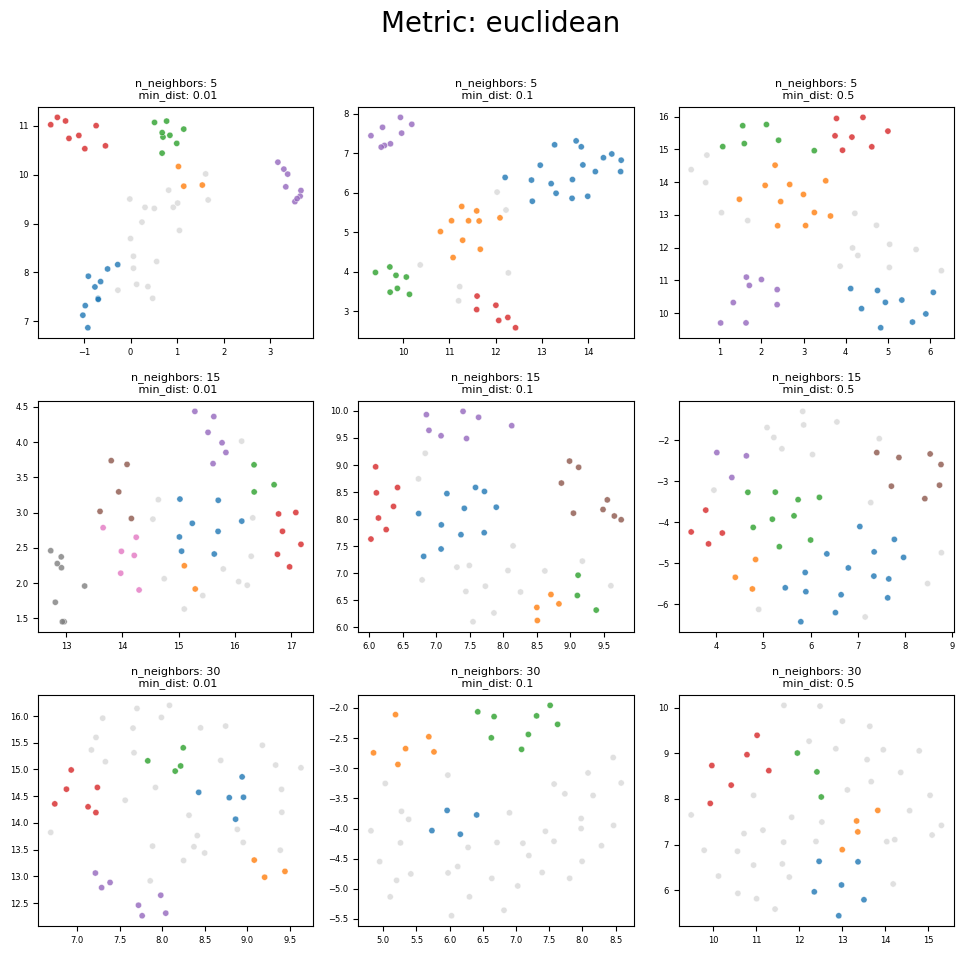

In [311]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        n_neighbors = params["n_neighbors"][i]
        min_dist = params["min_dist"][j]
        metric = params["metric"][0]
            
        plot_umap(patients_std, metric, n_neighbors, min_dist, axs[i][j])

fig.suptitle(f"Metric: {metric}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.show()

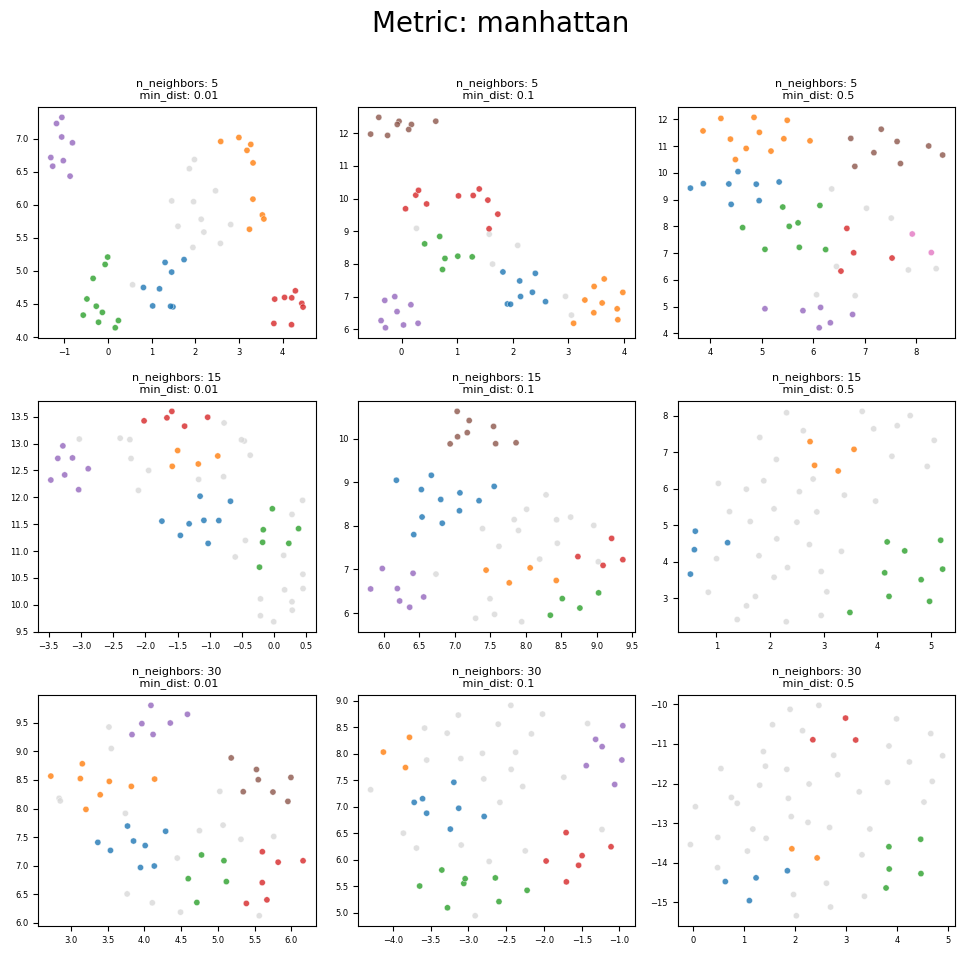

In [312]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        n_neighbors = params["n_neighbors"][i]
        min_dist = params["min_dist"][j]
        metric = params["metric"][1]
            
        plot_umap(patients_std, metric, n_neighbors, min_dist, axs[i][j])

fig.suptitle(f"Metric: {metric}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.show()

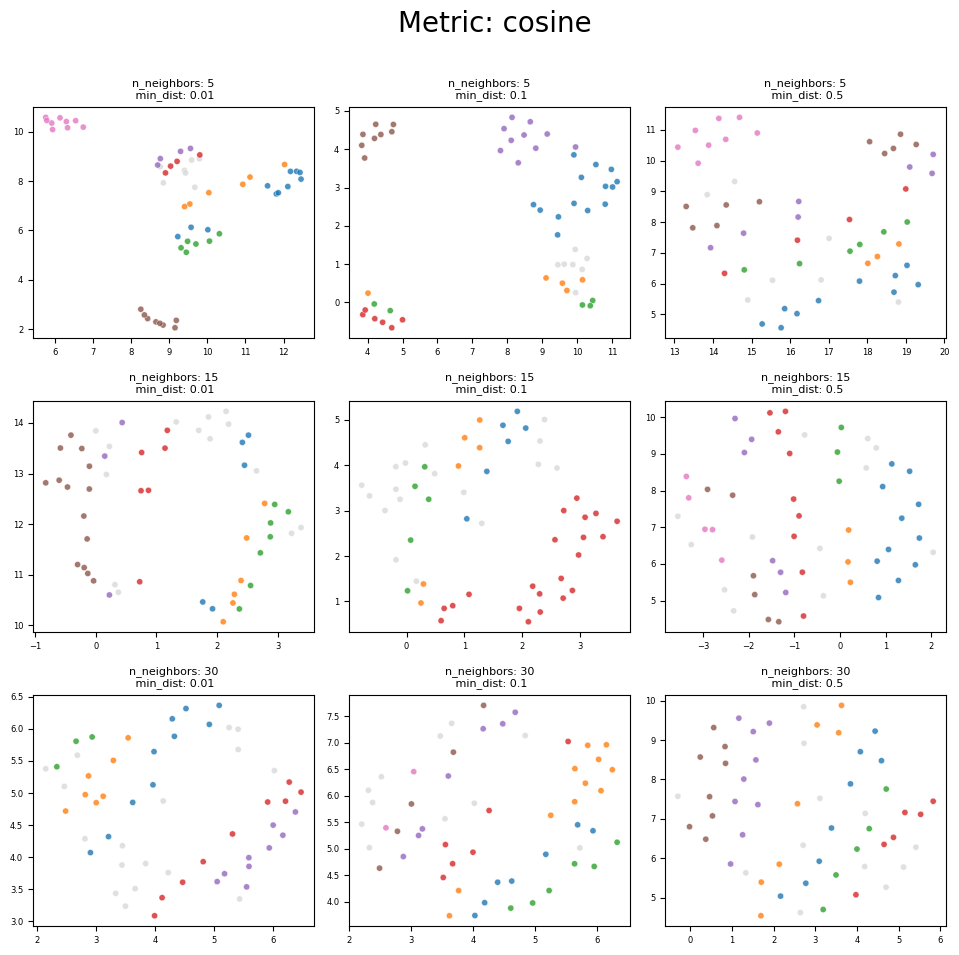

In [313]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        n_neighbors = params["n_neighbors"][i]
        min_dist = params["min_dist"][j]
        metric = params["metric"][2]
            
        plot_umap(patients_std, metric, n_neighbors, min_dist, axs[i][j])

fig.suptitle(f"Metric: {metric}", fontsize = 20)

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 0.97, 0.97])  # Leaves space for suptitle

plt.show()

In [317]:
def plot_reachability(X, metric, n_neighbors, min_dist, ax, plot_type="lineplot"):

    umap_model = umap.UMAP(
        n_neighbors=n_neighbors,         # smaller = more local focus, higher = more global
        min_dist=min_dist,           # smaller = tighter clusters, higher = more spread
        n_components=2,         
        metric=metric,     
        random_state=42
    )
    optics_model = OPTICS(
        min_samples=5,
        xi=0.05,              # sensitivity for cluster detection (lower = more sensitive)
        min_cluster_size=0.05, # fraction or count of minimum cluster size
        metric=metric     # must match UMAP if used for clustering
    )
    
    X_transformed = umap_model.fit_transform(X)
    
    optics_model.fit(X_transformed)
    labels = optics_model.labels_
    
    # Generate a color palette that matches the UMAP scatter plot
    clusters = np.unique(labels[labels != -1])  # exclude noise for coloring
    palette = sns.color_palette("tab10", n_colors=len(clusters))
    label_color_map = {label: palette[i] for i, label in enumerate(clusters)}
    label_color_map[-1] = (0.85, 0.85, 0.85)
    
    # Sort labels and reachability distances by OPTICS ordering
    space = np.arange(len(optics_model.ordering_))
    reachability = optics_model.reachability_[optics_model.ordering_]
    labels = optics_model.labels_[optics_model.ordering_]

    if plot_type == "lineplot":
        sns.lineplot(x=space, y=reachability, size=10, alpha=0.8, ax=ax, legend=False)
    else: 
        sns.scatterplot(x=space, y=reachability, hue=labels, palette=label_color_map, size=10, alpha=0.8, legend=False)
    
    # Layout
    ax.set_title(f"n_neighbors: {n_neighbors}\n min_dist: {min_dist}", fontsize=8) # Fontsize
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) # Limit decimal precision on ticks
    ax.tick_params(axis='both', labelsize=6) # Reduce tick label font size

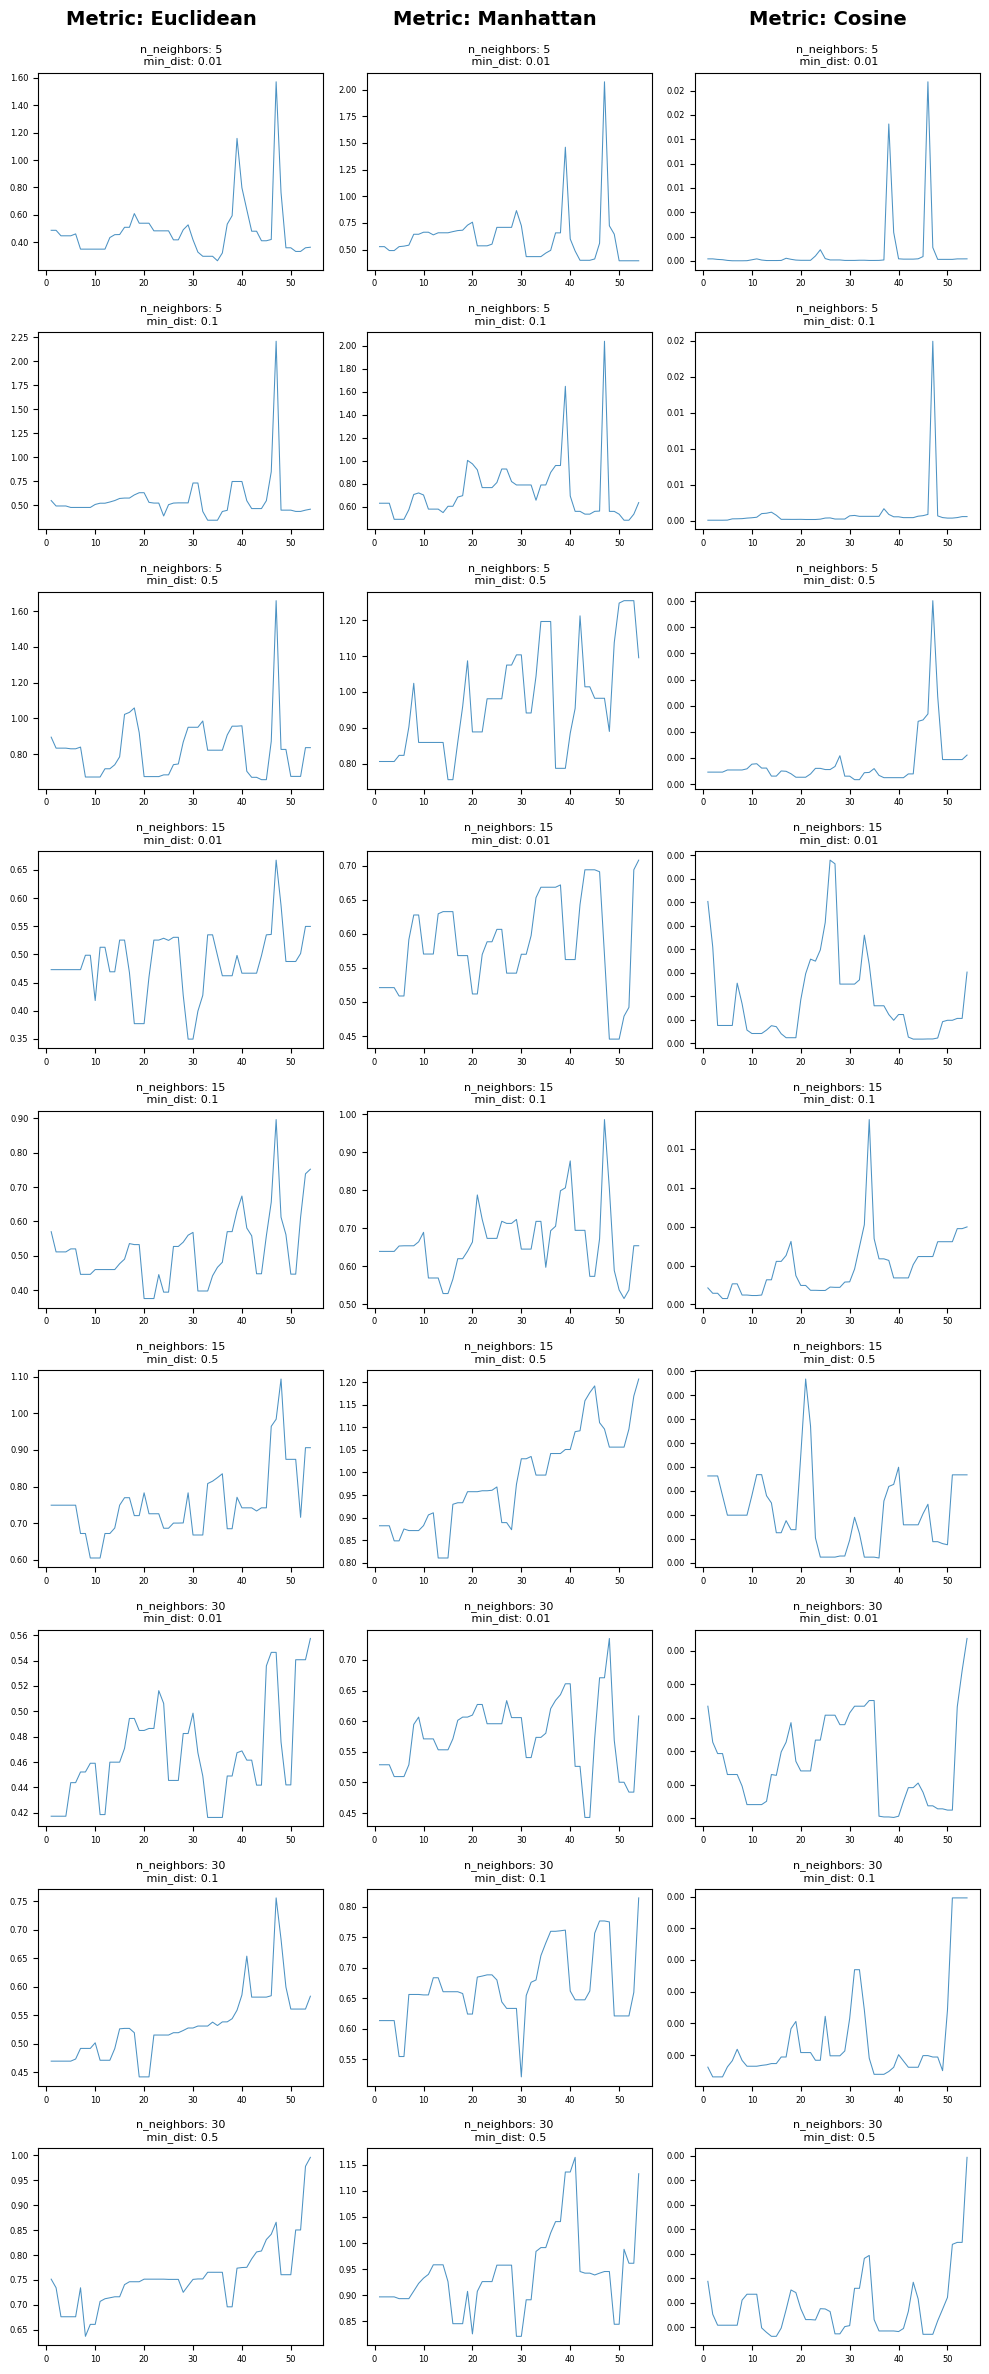

In [318]:
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(10,25));

for i in range(3):
    for j in range(3):
        for k in range(3):
            metric = params["metric"][i]
            n_neighbors = params["n_neighbors"][j]
            min_dist = params["min_dist"][k]
            
            plot_reachability(patients_std, metric, n_neighbors, min_dist, axs[j*3+k][i]);

plt.subplots_adjust(hspace=1.2)  # Increase vertical space
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Leaves space for suptitle

# Add subtitles
column_titles=["Euclidean", "Manhattan", "Cosine"]
for i, title in enumerate(column_titles):
    fig.text(x=(i + 0.5) / 3, y=0.97, s=f"Metric: {title}", ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.show()